<a href="https://colab.research.google.com/github/Dviteesha/Thesis-/blob/main/Taiwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === PART 1: Load Data + Combine IMUs + Window + Stratified Split (Improved) ===

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import entropy

# Load and merge all CSVs
print("📥 Loading IMU files...")
df_train = pd.read_csv('train.csv')
df_test1 = pd.read_csv('test1.csv')
df_test2 = pd.read_csv('test2.csv')

df = pd.concat([df_train, df_test1, df_test2], ignore_index=True)
print(f"✅ Total rows loaded: {df.shape[0]}")

# Clean: remove nulls + keep valid gesture rows only
df = df[df['y'] > 0].dropna()
df['y'] = df['y'].astype(int)
print(f"🧹 Cleaned rows (y > 0): {df.shape[0]}")

# Combine all 6 IMUs for each person + timestep
def combine_imus(df):
    grouped = df.groupby(['person', 't', 'y'])
    combined_features = []

    for (person, t, label), group in grouped:
        group = group.sort_values('IMU')  # Order IMUs 0–5
        if group.shape[0] == 6:
            row = []
            for col in ['q1', 'q2', 'q3', 'q4', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
                row += group[col].tolist()
            combined_features.append(row + [person, label])
    return pd.DataFrame(combined_features)

print("🔗 Combining IMUs into full-hand snapshots...")
combined_df = combine_imus(df)
print(f"✅ Combined dataset shape: {combined_df.shape} (features + person + label)")

# Extract features and labels
X_all = combined_df.iloc[:, :-2].to_numpy()  # all features
persons = combined_df.iloc[:, -2].to_numpy()
y_all = combined_df.iloc[:, -1].to_numpy()

# --- Sliding Window Feature Extraction ---
def extract_features(window):
    feats = []
    for i in range(window.shape[1]):
        signal = window[:, i]
        feats += [
            np.mean(signal), np.std(signal), np.max(signal), np.min(signal),
            np.sqrt(np.mean(signal**2)),
            np.sum(np.abs(np.diff(signal))),
            entropy(np.histogram(signal, bins=10)[0] + 1)
        ]
    return feats

def sliding_window_features(X, y, persons=None, window_size=10, step_size=5, group_by_person=True):
    X_feat, y_feat = [], []
    if group_by_person:
        unique = list(set(zip(persons, y)))
        for person_id, gesture in unique:
            mask = (persons == person_id) & (y == gesture)
            gesture_data = X[mask]
            for i in range(0, len(gesture_data) - window_size + 1, step_size):
                window = gesture_data[i:i+window_size]
                X_feat.append(extract_features(window))
                y_feat.append(gesture)
    else:
        for gesture in np.unique(y):
            gesture_data = X[y == gesture]
            for i in range(0, len(gesture_data) - window_size + 1, step_size):
                window = gesture_data[i:i+window_size]
                X_feat.append(extract_features(window))
                y_feat.append(gesture)
    return np.array(X_feat), np.array(y_feat)

print("🪟 Extracting features with sliding window...")
X_feat, y_feat = sliding_window_features(X_all, y_all, persons, window_size=10, step_size=5)

# Final train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_feat, test_size=0.2, stratify=y_feat, random_state=42
)

print(f"📊 Final split — Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")


📥 Loading IMU files...
✅ Total rows loaded: 21350
🧹 Cleaned rows (y > 0): 14357
🔗 Combining IMUs into full-hand snapshots...
✅ Combined dataset shape: (1727, 62) (features + person + label)
🪟 Extracting features with sliding window...
📊 Final split — Train: 179, Test: 45


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import random

def get_reward(y_pred, y_true, p_plus=0.5, p_minus=2):
    return p_plus if y_pred != y_true else -p_minus

def roar_algorithm(X, y, theta=0.9, epsilon=0.05, eta=0.05, budget=100):
    clf = RandomForestClassifier()
    X_train, y_train = [], []
    predictions = []
    reward_list = []
    n_queries = 0

    print("🚀 Starting ROAR training loop...\n")

    for i in range(len(X)):
        x = X[i].reshape(1, -1)
        true_label = y[i]

        if len(X_train) == 0:
            X_train.append(x[0])
            y_train.append(true_label)
            clf.fit(X_train, y_train)
            predictions.append(true_label)
            n_queries += 1
            continue

        proba = clf.predict_proba(x)[0]
        confidence = np.max(proba)
        y_pred = np.argmax(proba)
        r = random.random()

        query = r < epsilon or confidence < theta

        if query and n_queries < budget:
            X_train.append(x[0])
            y_train.append(true_label)
            clf.fit(X_train, y_train)
            reward = get_reward(y_pred, true_label)
            theta = min(theta * (1 + eta * (1 - 2 * reward / 2)), 1)
            reward_list.append(reward)
            predictions.append(true_label)
            n_queries += 1
        else:
            predictions.append(y_pred)

    print(f"📈 ROAR training done. Labels queried: {n_queries}\n")
    return predictions, n_queries, reward_list


🚀 Starting ROAR training loop...

📈 ROAR training done. Labels queried: 29

🎯 ROAR Test Set Evaluation Summary
✔️ Test Accuracy: 0.8444 (~84.4% correct predictions)
📊 Macro F1 Score: 0.8299 (balanced across gesture digits)
🔍 Queried Labels: 29 out of 179 samples


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


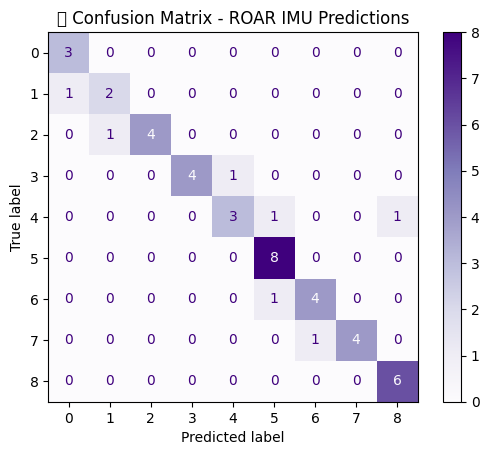

In [3]:
# Run ROAR
preds_train, queries_used, rewards = roar_algorithm(X_train, y_train, budget=100)

# Evaluate on test set
clf_eval = RandomForestClassifier()
clf_eval.fit(X_train, y_train)
y_pred_test = clf_eval.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

acc = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='macro')

print("🎯 ROAR Test Set Evaluation Summary")
print(f"✔️ Test Accuracy: {acc:.4f} (~{acc*100:.1f}% correct predictions)")
print(f"📊 Macro F1 Score: {f1:.4f} (balanced across gesture digits)")
print(f"🔍 Queried Labels: {queries_used} out of {len(X_train)} samples")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Purples')
plt.title("🧾 Confusion Matrix - ROAR IMU Predictions")
plt.grid(False)
plt.show()


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def run_baseline(X_train, y_train, X_test, y_test):
    print("\n🏁 Running Baseline: Fully Supervised Random Forest")
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Baseline Accuracy: {acc:.4f}")
    print(f"📊 Baseline Macro F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Greens')
    plt.title("🧾 Confusion Matrix - Baseline Model")
    plt.grid(False)
    plt.show()

    return acc, f1


In [5]:
import random

def run_random_sampling(X_train, y_train, X_test, y_test, budget=100):
    print(f"\n🎲 Running Random Sampling Strategy (budget = {budget})")

    indices = list(range(len(X_train)))
    random.shuffle(indices)
    queried_idx = indices[:budget]

    X_sampled = X_train[queried_idx]
    y_sampled = y_train[queried_idx]

    clf = RandomForestClassifier()
    clf.fit(X_sampled, y_sampled)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Random Sampling Accuracy: {acc:.4f}")
    print(f"📊 Random Sampling Macro F1 Score: {f1:.4f}")
    print(f"🔍 Queried Labels: {len(y_sampled)}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Oranges')
    plt.title("🧾 Confusion Matrix - Random Sampling")
    plt.grid(False)
    plt.show()

    return acc, f1



🏁 Running Baseline: Fully Supervised Random Forest
✅ Baseline Accuracy: 0.8667
📊 Baseline Macro F1 Score: 0.8562


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


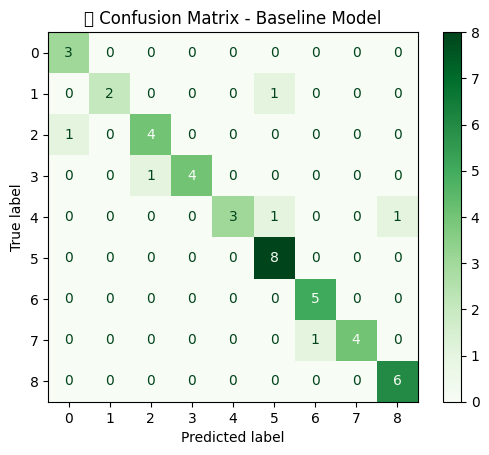


🎲 Running Random Sampling Strategy (budget = 100)
✅ Random Sampling Accuracy: 0.8000
📊 Random Sampling Macro F1 Score: 0.7534
🔍 Queried Labels: 100


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


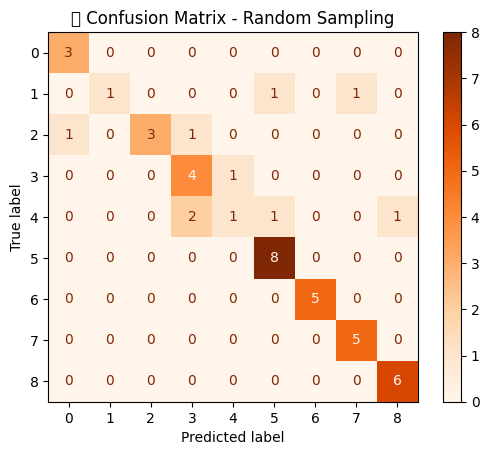


🔍 Summary Comparison:
Baseline (Full Supervised):  Acc = 0.8667, F1 = 0.8562
Random Sampling (100 labels): Acc = 0.8000, F1 = 0.7534
ROAR (100 labels):            Acc = 0.8444, F1 = 0.8299


In [6]:
# Run Baseline
baseline_acc, baseline_f1 = run_baseline(X_train, y_train, X_test, y_test)

# Run Random Sampling
random_acc, random_f1 = run_random_sampling(X_train, y_train, X_test, y_test, budget=100)

# ROAR already run previously:
# preds_train, queries_used, rewards = roar_algorithm(...)
# clf_eval = RandomForestClassifier().fit(X_train_ROAR, y_train_ROAR)
# y_pred_test = clf_eval.predict(X_test)
# -> compute accuracy + f1 + confusion matrix

# Compare summary (optional)
print("\n🔍 Summary Comparison:")
print(f"Baseline (Full Supervised):  Acc = {baseline_acc:.4f}, F1 = {baseline_f1:.4f}")
print(f"Random Sampling (100 labels): Acc = {random_acc:.4f}, F1 = {random_f1:.4f}")
print(f"ROAR (100 labels):            Acc = {acc:.4f}, F1 = {f1:.4f}")
